We will not be doing any feature selection on this because we are not as interested in the tri class problem. We are simply doing this to explore if it is worth pursuing further.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from lightgbm import LGBMClassifier

Here we are just doing some data preprocessing. Removing ipswich because they only occur in the last season so no relevant stats and removing the 14/15 season because it was used for building stats and is not relevant.

In [ ]:
# load data

df = pd.read_csv("data_1.csv")

# drop first column, team names now that hayden processed the data

df = df.iloc[:, 1:]
df.head()
print('Games before removing Ipswich', len(df))
df = df[(df['HomeTeam'] != 'Ipswich') & (df['AwayTeam'] != 'Ipswich')]
print('Games after removing Ipswich', len(df))
df = df.drop(columns=['HomeTeam', 'AwayTeam'])

# df['FTR'] = df['FTR'].replace('D', 'A')
# then label encode results
label_encoder = LabelEncoder()
df['FTR'] = label_encoder.fit_transform(df['FTR'])
# df['HTR'] = label_encoder.fit_transform(df['HTR'])

df = df[(df['Date'] >= '2015-07-01')]
print('Games after removing unnecessary first season only used for stat building', len(df))
# then split 2024-2025 season
df_pastSeasons = df[(df['Date'] < '2023-07-01')]
df_currentSeason = df[df['Date'] >= '2023-07-01']

print('Train%', len(df_pastSeasons) / (len(df_currentSeason) + len(df_pastSeasons)))
print('Test%', len(df_currentSeason) / (len(df_pastSeasons) + len(df_currentSeason)))
# then remove dates from both datasets
df_pastSeasons = df_pastSeasons.drop(columns=['Date'])
df_currentSeason = df_currentSeason.drop(columns=['Date'])

#save
# df_pastSeasons.to_csv("Binary_Training_HTR.csv", index=False)
# df_currentSeason.to_csv("Binary_Testing_HTR.csv", index=False)



# df_pastSeasons['FTR'] = label_encoder.fit_transform(df_pastSeasons['FTR'])
# df_currentSeason['FTR'] = label_encoder.fit_transform(df_currentSeason['FTR'])
for name, index in enumerate(label_encoder.classes_):
    print(name, index)
print('Overall Home Team wins', df['FTR'].value_counts()[2] / len(df))
print('Overall Away Team wins', df['FTR'].value_counts()[0] / len(df))
print('Overall Draw', df['FTR'].value_counts()[1] / len(df))
# print('Overall Home Team Wins', df['FTR'].value_counts()[1] / len(df))
# print('Overall Home Team Non-Wins', df['FTR'].value_counts()[0] / len(df))
# training
X_train = df_pastSeasons.drop(columns=['FTR'])
y_train = df_pastSeasons['FTR']
X_test = df_currentSeason.drop(columns=['FTR'])
y_test = df_currentSeason['FTR']
# X_train, X_test, y_train, y_test = train_test_split(df.drop(['FTR', 'Date'], axis=1), df['FTR'], test_size = 0.2, random_state = 42)
print(np.unique(y_train))
print('Train%', len(y_train) / (len(y_test) + len(y_train)))
print('Test%', len(y_test) / (len(y_test) + len(y_train)))

# df.head()


Games before removing Ipswich 4071
Games after removing Ipswich 4044
Games after removing unnecessary first season only used for stat building 3664
Train% 0.8296943231441049
Test% 0.1703056768558952
0 A
1 D
2 H
Overall Home Team wins 0.4462336244541485
Overall Away Team wins 0.3212336244541485
Overall Draw 0.23253275109170304
[0 1 2]
Train% 0.8296943231441049
Test% 0.1703056768558952


In [ ]:
scaler = MinMaxScaler()
# Minmax appears to work better than standard
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Function for printing confusion matrices and evaluation metrics

In [ ]:
def print_cm(y_test, this_y_pred, method, Encoder=False, class_report = False):
  if class_report:
    print(classification_report(y_test, this_y_pred))
  print("Accuracy:", accuracy_score(y_test, this_y_pred))
  print("Precision:", precision_score(y_test, this_y_pred, average=method))
  print("Recall:", recall_score(y_test, this_y_pred, average=method))
  print("F1 Score:", f1_score(y_test, this_y_pred, average=method))

  confusion = confusion_matrix(y_test, this_y_pred)
  sns.heatmap(confusion,
              annot=True,
              fmt='d',
              xticklabels = [class_name for class_name in Encoder.classes_ if Encoder],
              yticklabels = [class_name for class_name in Encoder.classes_ if Encoder]
              )
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

Now lets tune a basic svm and see how it does

In [ ]:
svm_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
}

svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best Parameters Accuracy:", svm_grid.best_params_)
print("Best Score Accuracy:", svm_grid.best_score_)


svm_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='f1_macro', n_jobs=-1, error_score='raise')
svm_grid.fit(X_train, y_train)

print("Best Parameters F1:", svm_grid.best_params_)
print("Best Score F1:", svm_grid.best_score_)


Best Parameters Accuracy: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score Accuracy: 0.5328947368421053
Best Parameters F1: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score F1: 0.4183478573227061


Accuracy: 0.5319078947368421
Precision: 0.35147494383163175
Recall: 0.44704231210643613
F1 Score: 0.3902121632449826


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


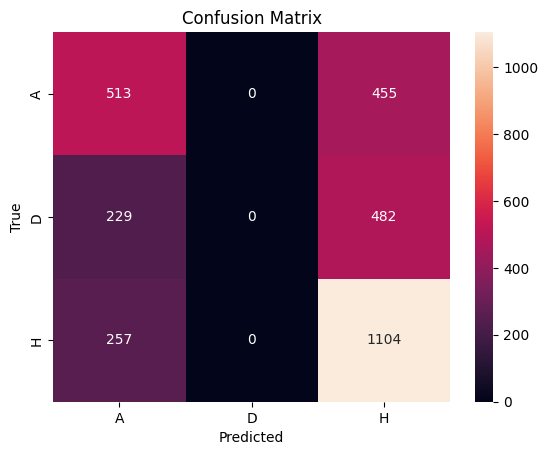

              precision    recall  f1-score   support

           0       0.56      0.56      0.56       209
           1       0.00      0.00      0.00       141
           2       0.54      0.82      0.65       274

    accuracy                           0.55       624
   macro avg       0.37      0.46      0.40       624
weighted avg       0.43      0.55      0.47       624

Accuracy: 0.5480769230769231
Precision: 0.36811744585999495
Recall: 0.46070384987019636
F1 Score: 0.40493700275229566


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

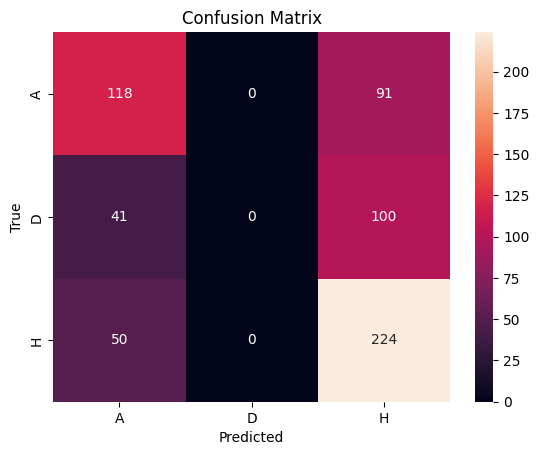

In [ ]:
# SVM with Accuracy scored parameters
svm_model = SVC(kernel='linear', C=0.1, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
print_cm(y_train, svm_model.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, svm_y_pred, 'macro', Encoder=label_encoder, class_report=True)

# svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
# svm_model.fit(X_train, y_train)
# svm_y_pred = svm_model.predict(X_test)

SVM didnt predict a single draw! Now lets use SMOTE to address the class imbalance and check again.

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
smote_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='accuracy', n_jobs=-1)
smote_grid.fit(X_resampled, y_resampled)

print("Best Parameters Accuracy:", smote_grid.best_params_)
print("Best Score Accuracy:", smote_grid.best_score_)

smote_grid = GridSearchCV(SVC(), svm_params, cv=5, scoring='f1_macro', n_jobs=-1)
smote_grid.fit(X_resampled, y_resampled)

print("Best Parameters F1:", smote_grid.best_params_)
print("Best Score F1:", smote_grid.best_score_)

Best Parameters Accuracy: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score Accuracy: 0.5386054911560707
Best Parameters F1: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score F1: 0.5368017966455787


3040 4083
Accuracy: 0.6806269899583639
Precision: 0.6833966734058731
Recall: 0.6806269899583639
F1 Score: 0.6802508380998784


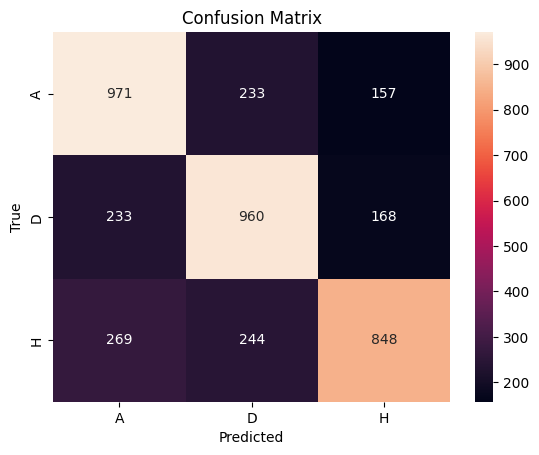

              precision    recall  f1-score   support

           0       0.47      0.47      0.47       209
           1       0.25      0.28      0.26       141
           2       0.61      0.56      0.58       274

    accuracy                           0.47       624
   macro avg       0.44      0.44      0.44       624
weighted avg       0.48      0.47      0.47       624

Accuracy: 0.46794871794871795
Precision: 0.44212969914091804
Recall: 0.43858877145755626
F1 Score: 0.4395229122926649


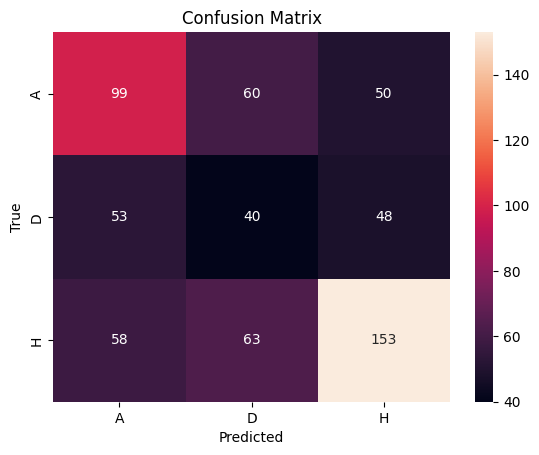

In [ ]:
smote_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
smote_model.fit(X_resampled, y_resampled)
print(len(X_train), len(X_resampled))
smote_y_pred = smote_model.predict(X_test)
print_cm(y_resampled, smote_model.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, smote_y_pred, 'macro', Encoder=label_encoder, class_report=True)


Evaluation metrics have absolutely tanked. Draws are hard to predict! But at least now we are predicting some draws.

Next lets take a look at the same SVM but this time lets add some weights to the classes that performed the worst.

3040 4083
Accuracy: 0.6847905951506246
Precision: 0.7052780740960111
Recall: 0.6847905951506245
F1 Score: 0.6802130162600099


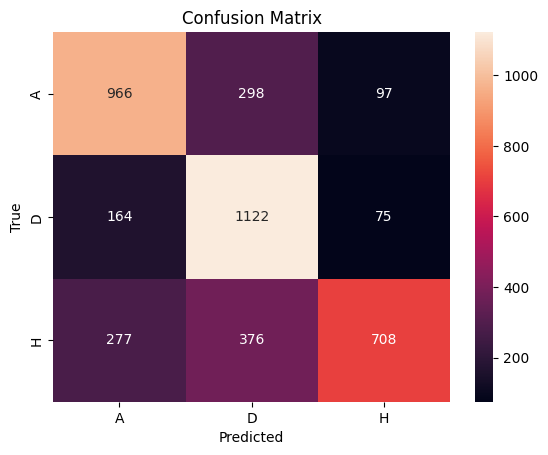

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       209
           1       0.23      0.35      0.28       141
           2       0.59      0.42      0.49       274

    accuracy                           0.43       624
   macro avg       0.43      0.42      0.42       624
weighted avg       0.47      0.43      0.44       624

Accuracy: 0.42628205128205127
Precision: 0.43219114354233046
Recall: 0.4191905155972803
F1 Score: 0.4165149008187891


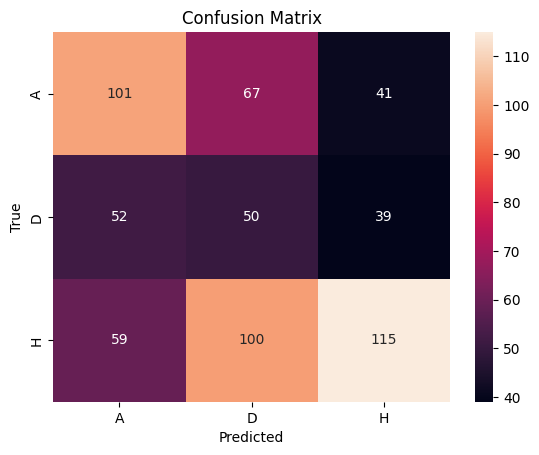

In [ ]:
class_weight = {2: 1.0, 1: 1.5, 0: 1.25}
smote_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, class_weight=class_weight)
smote_model.fit(X_resampled, y_resampled)
print(len(X_train), len(X_resampled))
smote_y_pred = smote_model.predict(X_test)
print_cm(y_resampled, smote_model.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, smote_y_pred, 'macro', Encoder=label_encoder, class_report=True)

We are doing even worse now! Draws are really screwing us up here.

Lets define a custom function and play with the weights again. Using a calibrator we can get a better idea of probabilities. If an SVM predicts 90% probability but only get it right 60% of the time, 90% isn't a probability we should be using. This is what the calibratied classifier addresses. Once we have calibrated probabilities we can perfrom threshold tuning. First we will look at if draw and win is really close, and the probability of a draw is higher than a loss/win then we will saw draw.

Accuracy: 0.6710751898114132
Precision: 0.6754242919069204
Recall: 0.6710751898114132
F1 Score: 0.6699089921637481


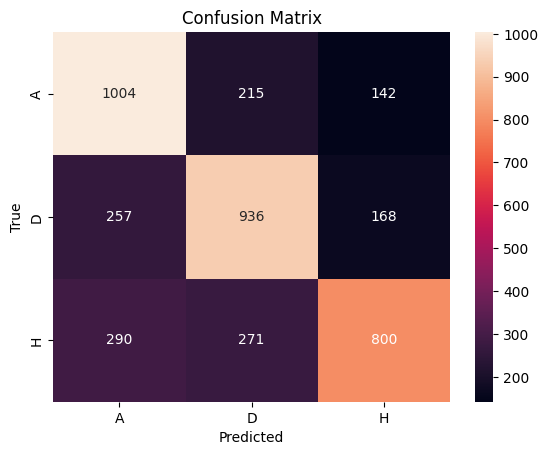

              precision    recall  f1-score   support

           0       0.49      0.49      0.49       209
           1       0.27      0.33      0.30       141
           2       0.62      0.53      0.57       274

    accuracy                           0.47       624
   macro avg       0.46      0.45      0.45       624
weighted avg       0.49      0.47      0.48       624

Accuracy: 0.47435897435897434
Precision: 0.45734888963809794
Recall: 0.45300100505632585
F1 Score: 0.4528909445827534


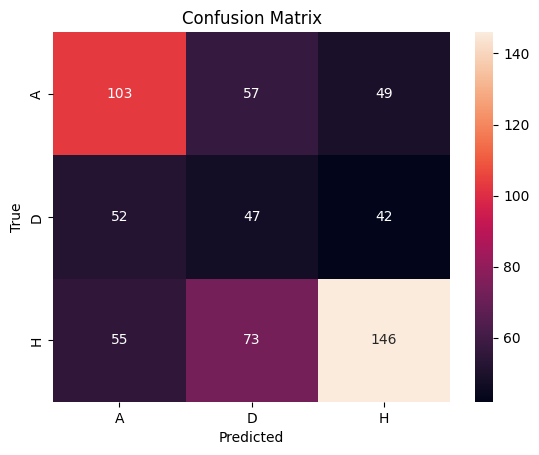

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

class_weight = {2: 1.0, 1: 1.25, 0: 1.25}
base_svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, class_weight=class_weight)
calibrated_svm = CalibratedClassifierCV(base_svm, method='sigmoid', cv=5)
calibrated_svm.fit(X_resampled, y_resampled)
probs = calibrated_svm.predict_proba(X_test)
classes = calibrated_svm.classes_
custom_preds = []
for prob in probs:
    p_draw = prob[classes.tolist().index(1)]
    p_win = prob[classes.tolist().index(2)]
    p_loss = prob[classes.tolist().index(0)]
    # if abs(p_win - p_loss) < 0.1 and p_draw > 0.2:
    #     custom_preds.append(1)
    if abs(p_win - p_draw) < 0.05 and (p_loss < p_win and p_loss < p_draw):
        custom_preds.append(1)
    elif abs(p_draw - p_loss) < 0.05 and (p_win < p_loss and p_win < p_draw):
        custom_preds.append(1)
    else:
        custom_preds.append(np.argmax(prob))

print_cm(y_resampled, calibrated_svm.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, custom_preds, 'macro', Encoder=label_encoder, class_report=True)

Well that didnt appear to do much. Now we will take a look at if draws and wins are really close and draw is above a certain threshold, say draw.

Accuracy: 0.6710751898114132
Precision: 0.6754242919069204
Recall: 0.6710751898114132
F1 Score: 0.6699089921637481


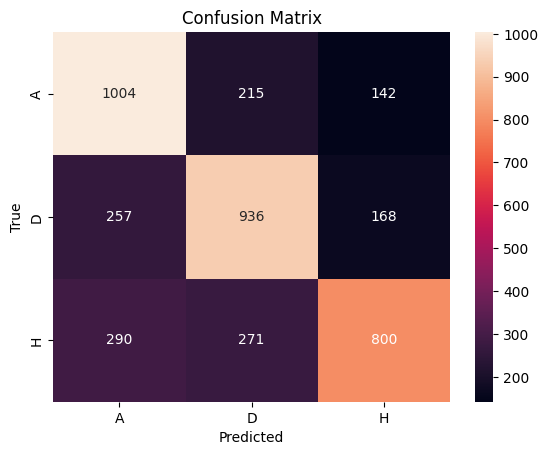

              precision    recall  f1-score   support

           0       0.50      0.49      0.49       209
           1       0.27      0.33      0.30       141
           2       0.62      0.55      0.59       274

    accuracy                           0.48       624
   macro avg       0.46      0.46      0.46       624
weighted avg       0.50      0.48      0.49       624

Accuracy: 0.483974358974359
Precision: 0.4634847573757348
Recall: 0.46030027512931854
F1 Score: 0.4603428862068193


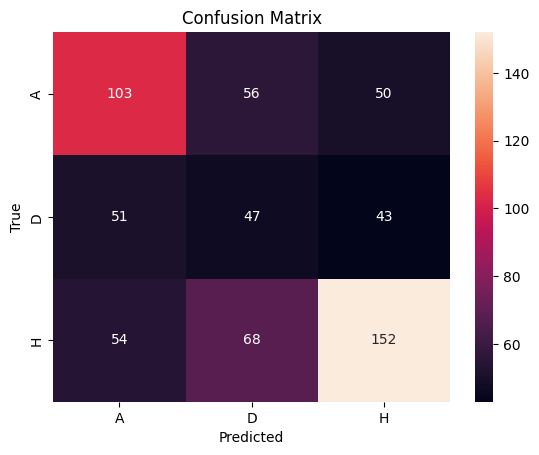

In [ ]:
class_weight = {2: 1.0, 1: 1.25, 0: 1.25}
base_svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42, class_weight=class_weight)
calibrated_svm = CalibratedClassifierCV(base_svm, method='sigmoid', cv=5)
calibrated_svm.fit(X_resampled, y_resampled)
probs = calibrated_svm.predict_proba(X_test)
classes = calibrated_svm.classes_
custom_preds = []
for prob in probs:
    p_draw = prob[classes.tolist().index(1)]
    p_win = prob[classes.tolist().index(2)]
    p_loss = prob[classes.tolist().index(0)]
    if abs(p_win - p_loss) < 0.1 and p_draw > 0.2:
        custom_preds.append(1)
    # if abs(p_win - p_draw) < 0.2 and (p_loss < p_win and p_loss < p_draw):
    #     custom_preds.append(1)
    # elif abs(p_draw - p_loss) < 0.2 and (p_win < p_loss and p_win < p_draw):
    #     custom_preds.append(1)
    else:
        custom_preds.append(np.argmax(prob))

print_cm(y_resampled, calibrated_svm.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, custom_preds, 'macro', Encoder=label_encoder, class_report=True)

Thats a bit better. Keep this in our bag of tricks

Now lets check a RF

In [ ]:
rf_params = {
    'n_estimators': [10, 100, 50],
    'max_depth': [None, 10, 50],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_resampled, y_resampled)

print("Best Parameters Accuracy:", rf_grid.best_params_)
print("Best Score Accuracy:", rf_grid.best_score_)


rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='f1_macro', n_jobs=-1)
rf_grid.fit(X_resampled, y_resampled)

print("Best Parameters F1:", rf_grid.best_params_)
print("Best Score F1:", rf_grid.best_score_)

Best Parameters Accuracy: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score Accuracy: 0.638063695490436
Best Parameters F1: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score F1: 0.6423123961776586


Really weird parameters and we are definitely going to overfit here so play with parameters a bit.

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


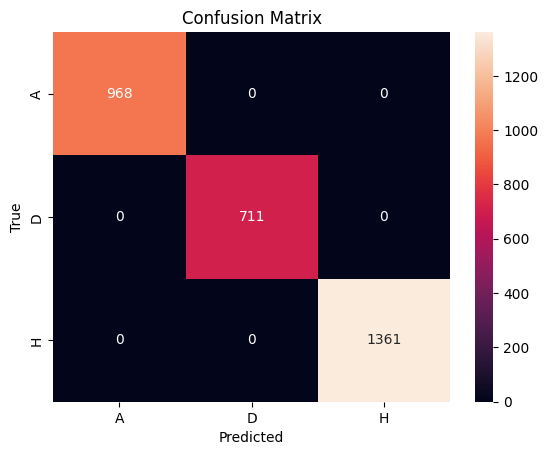

Accuracy: 0.5272435897435898
Precision: 0.4437410086754219
Recall: 0.4468428574247556
F1 Score: 0.40850080710250203


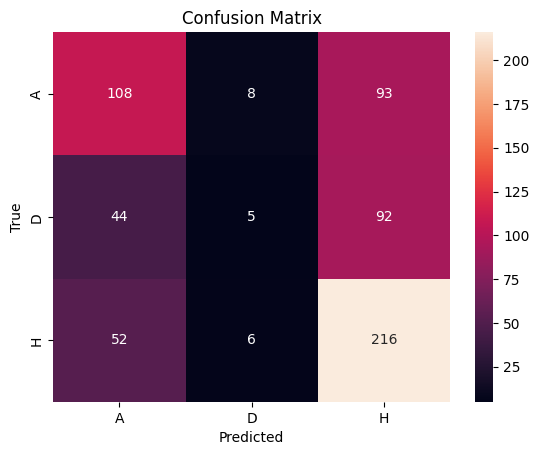

Accuracy: 0.9858552631578947
Precision: 0.9854811373251963
Recall: 0.987778138745008
F1 Score: 0.9866080033317969


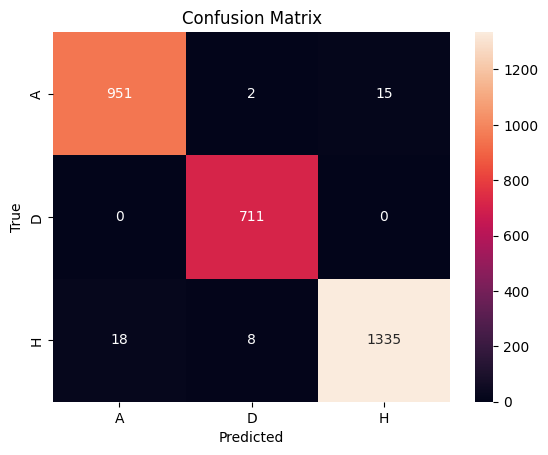

              precision    recall  f1-score   support

           0       0.55      0.52      0.53       209
           1       0.24      0.20      0.22       141
           2       0.60      0.69      0.64       274

    accuracy                           0.52       624
   macro avg       0.47      0.47      0.46       624
weighted avg       0.50      0.52      0.51       624

Accuracy: 0.5192307692307693
Precision: 0.4652881472755881
Recall: 0.46715311954275185
F1 Score: 0.4643658142784828


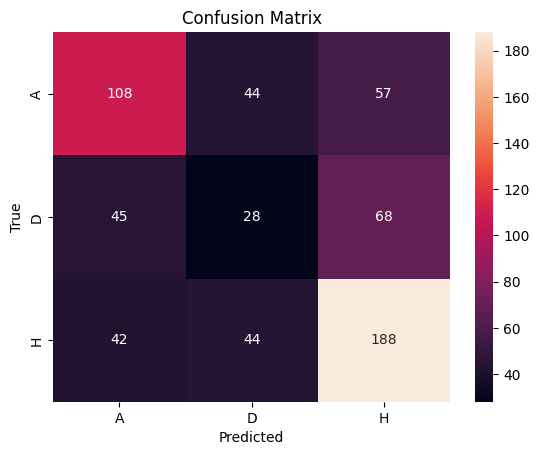

In [ ]:
class_weight = {2: 1.0, 1: 10, 0: 1.5}
rf_model = RandomForestClassifier(n_estimators=100, max_depth= None, random_state=42, min_samples_leaf=1, min_samples_split=2, class_weight=class_weight)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

print_cm(y_train, rf_model.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, rf_y_pred, 'macro', Encoder=label_encoder)

rf_model = RandomForestClassifier(n_estimators=100, max_depth= 50, random_state=42, min_samples_leaf=2, min_samples_split=5, class_weight=class_weight)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

print_cm(y_train, rf_model.predict(X_train), 'macro', Encoder=label_encoder)
print_cm(y_test, rf_y_pred, 'macro', Encoder=label_encoder, class_report=True)

Overfitting like crazy.

Next try some logistic regression. Pretty lightweight and usually will do well

In [ ]:
lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'max_iter': [10000]
    }

lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_resampled, y_resampled)

print("Best Parameters Accuracy:", lr_grid.best_params_)
print("Best Score Accuracy:", lr_grid.best_score_)


lr_grid = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='f1_macro', n_jobs=-1, error_score='raise')
lr_grid.fit(X_resampled, y_resampled)

print("Best Parameters F1:", lr_grid.best_params_)
print("Best Score F1:", lr_grid.best_score_)

Best Parameters Accuracy: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score Accuracy: 0.46510457916336667
Best Parameters F1: {'C': 10, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score F1: 0.4539261493501284


Accuracy: 0.48322312025471464
Precision: 0.4933021397662733
Recall: 0.48322312025471464
F1 Score: 0.483891168825861


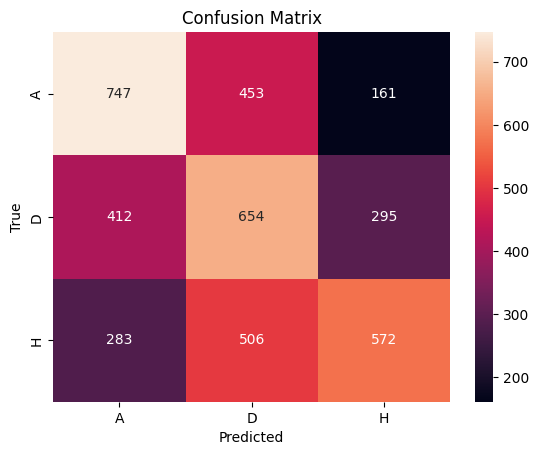

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       209
           1       0.27      0.43      0.33       141
           2       0.68      0.46      0.54       274

    accuracy                           0.48       624
   macro avg       0.49      0.47      0.47       624
weighted avg       0.53      0.48      0.49       624

Accuracy: 0.47596153846153844
Precision: 0.490664515149641
Recall: 0.47330965716870693
F1 Score: 0.4682012527291652


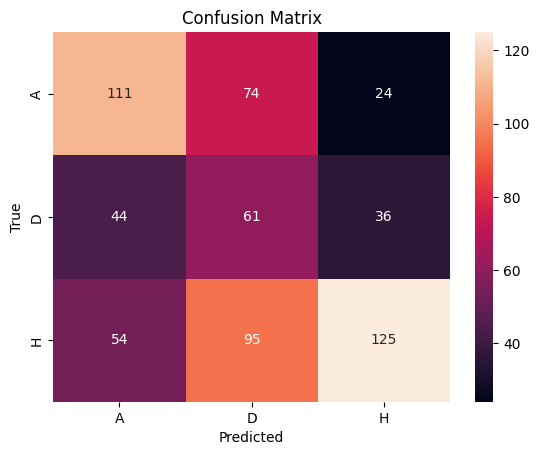

In [ ]:
class_weight = {2: 1.0, 1: 1.5, 0: 1.25}
lr_model = LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=10000, class_weight=class_weight)
lr_model.fit(X_resampled, y_resampled)
lr_y_pred = lr_model.predict(X_test)
print_cm(y_resampled, lr_model.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, lr_y_pred, 'macro', Encoder=label_encoder, class_report=True)

Again not fantastic stats. Its predicting draws incorrectly wayyyy more than correctly.

Now lets look at a 1v1 classifier. The idea here is that forcing the model to classify binary results will help it overall.

Accuracy: 0.47293656625030617
Precision: 0.4701812953913396
Recall: 0.47293656625030617
F1 Score: 0.45983578069461845


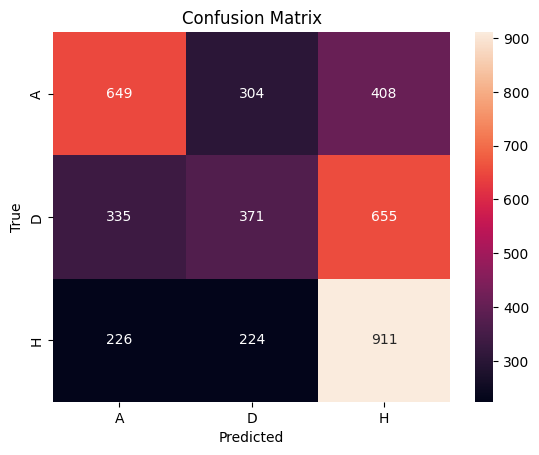

              precision    recall  f1-score   support

           0       0.58      0.48      0.53       209
           1       0.29      0.27      0.28       141
           2       0.60      0.70      0.65       274

    accuracy                           0.53       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.52      0.53      0.53       624

Accuracy: 0.532051282051282
Precision: 0.4920931731482661
Recall: 0.48571223221994425
F1 Score: 0.48587870696097796


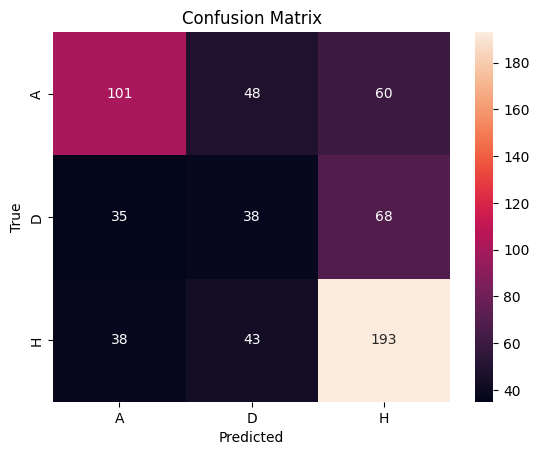

In [ ]:
# Logistic Regression 1 vs 1
from sklearn.multiclass import OneVsOneClassifier
class_weight = {2: 1.0, 1: 1.5, 0: 1.25}
# Train logistic regression with One-vs-One
clf_ovo = OneVsOneClassifier(LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=1000, class_weight=class_weight))
# clf_ovo = OneVsOneClassifier(RandomForestClassifier(n_estimators=100, max_depth= None, random_state=42, min_samples_leaf=1, min_samples_split=2, class_weight=class_weight))
# clf_ovo = OneVsOneClassifier(SVC(kernel='rbf', C=10, gamma='scale', random_state=42, class_weight=class_weight))
clf_ovo.fit(X_resampled, y_resampled)
lr1_y_pred = clf_ovo.predict(X_test)

print_cm(y_resampled, clf_ovo.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, lr1_y_pred, 'macro', Encoder=label_encoder, class_report=True)

The logistic regression performed the best so lets use this. This is actually the best result we've gotten so far!!!

Next we check naive bayes. Super lightweight and may not perform great but we will see

In [ ]:
nb_params = {
    'var_smoothing': [1e-15, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
}

nb_grid = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid.fit(X_train, y_train)

print("Best Parameters Accuracy:", nb_grid.best_params_)
print("Best Score Accuracy:", nb_grid.best_score_)

nb_grid = GridSearchCV(GaussianNB(), nb_params, cv=5, scoring='f1_macro', n_jobs=-1)
nb_grid.fit(X_train, y_train)

print("Best Parameters F1:", nb_grid.best_params_)
print("Best Score F1:", nb_grid.best_score_)


Best Parameters Accuracy: {'var_smoothing': 1e-15}
Best Score Accuracy: 0.6342488851160816
Best Parameters F1: {'var_smoothing': 1e-15}
Best Score F1: 0.6263022447844223


Accuracy: 0.45211854028900317
Precision: 0.45747152504975314
Recall: 0.45211854028900317
F1 Score: 0.4171259395514692


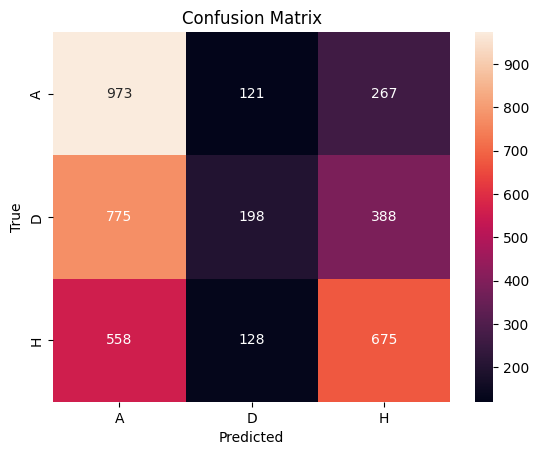

              precision    recall  f1-score   support

           0       0.49      0.70      0.57       209
           1       0.31      0.16      0.21       141
           2       0.62      0.56      0.59       274

    accuracy                           0.52       624
   macro avg       0.47      0.47      0.46       624
weighted avg       0.50      0.52      0.50       624

Accuracy: 0.5176282051282052
Precision: 0.47089474749639787
Recall: 0.47457631876591994
F1 Score: 0.4585167655823505


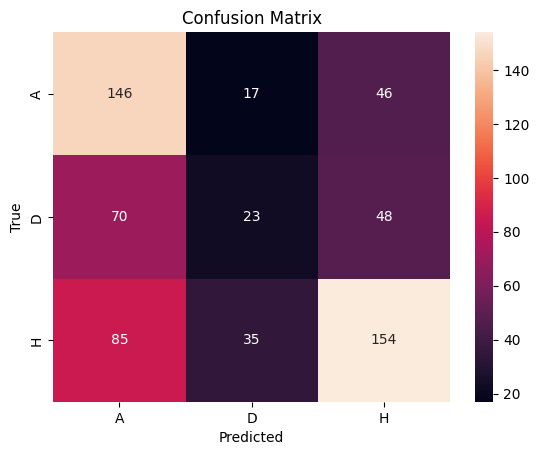

In [ ]:
nb_model = GaussianNB(var_smoothing=1e-15)
nb_model.fit(X_resampled, y_resampled)
nb_y_pred = nb_model.predict(X_test)

print_cm(y_resampled, nb_model.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, nb_y_pred, 'macro', Encoder=label_encoder, class_report=True)

Actually not terrible but the confusion matrix isnt great. Lets see if it works well in ensembles

We will keep RF out due to overfitting

Accuracy: 0.5116336027430811
Precision: 0.5365589485690603
Recall: 0.5116336027430811
F1 Score: 0.5073391965798273


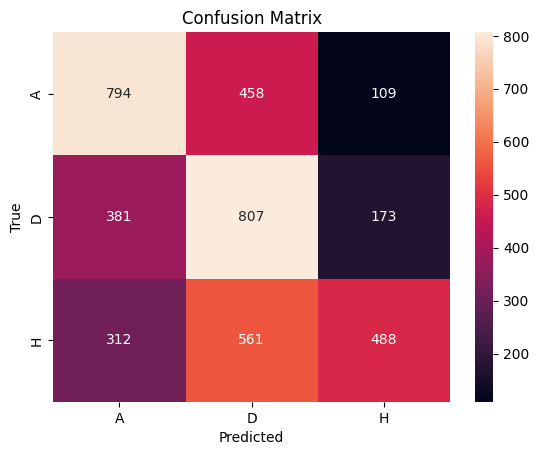

              precision    recall  f1-score   support

           0       0.53      0.56      0.55       209
           1       0.28      0.50      0.36       141
           2       0.70      0.39      0.50       274

    accuracy                           0.47       624
   macro avg       0.50      0.48      0.47       624
weighted avg       0.55      0.47      0.48       624

Accuracy: 0.47115384615384615
Precision: 0.5033496830661114
Recall: 0.48225782068484024
F1 Score: 0.4679227875949188


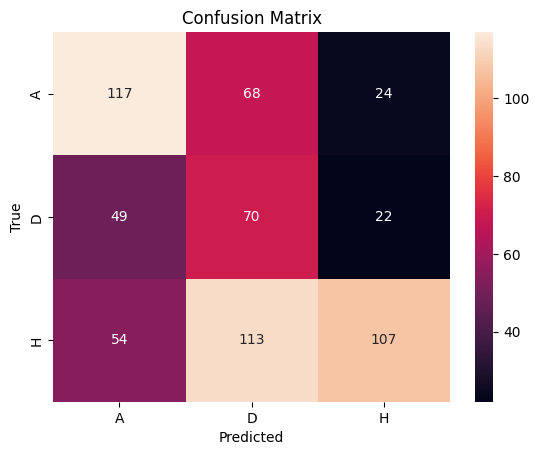

In [ ]:
# Hard voting
svm = SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42, class_weight=class_weight)
lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000, class_weight=class_weight)
nb = GaussianNB(var_smoothing=1e-15)

# seems to perform much better with either RF or NB taken out
voting_classifier = VotingClassifier(estimators=[('svm', svm), ('lr', lr), ('nb', nb)], voting='hard')
voting_classifier.fit(X_resampled, y_resampled)
print_cm(y_resampled, voting_classifier.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, voting_classifier.predict(X_test), 'macro', Encoder=label_encoder, class_report=True)

Not great. Draws still an issue.

Accuracy: 0.4878765613519471
Precision: 0.48961789900563524
Recall: 0.4878765613519471
F1 Score: 0.47296784863188307


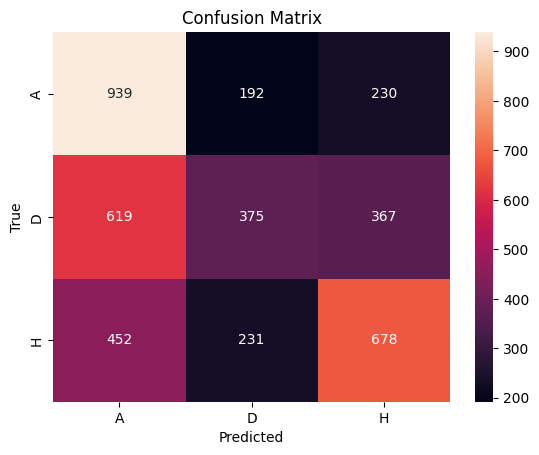

              precision    recall  f1-score   support

           0       0.51      0.66      0.58       209
           1       0.28      0.23      0.26       141
           2       0.63      0.55      0.59       274

    accuracy                           0.52       624
   macro avg       0.48      0.48      0.47       624
weighted avg       0.51      0.52      0.51       624

Accuracy: 0.5160256410256411
Precision: 0.47619159947389494
Recall: 0.4818081750140504
F1 Score: 0.47432477628498476


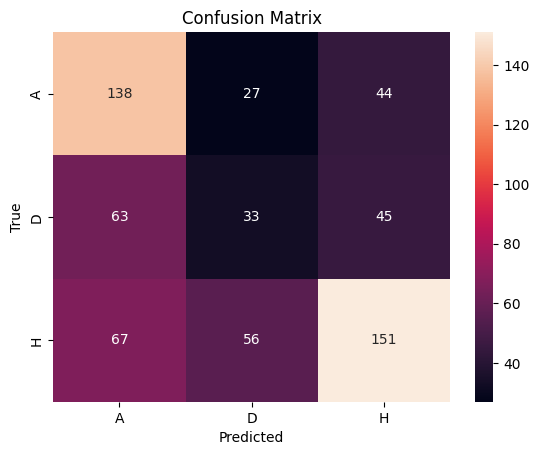

In [ ]:
# Soft voting
# svm = SVC(probability=True, kernel='rbf', C=10, gamma='scale', random_state=42)
# rf = RandomForestClassifier(n_estimators=100, max_depth= 10, random_state=42, min_samples_leaf=2, min_samples_split=5)
# lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000)
# nb = GaussianNB(var_smoothing=1e-15)
svm = SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42, class_weight=class_weight)
lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000, class_weight=class_weight)
nb = GaussianNB(var_smoothing=1e-15)

voting_classifier = VotingClassifier(estimators=[('svm', svm), ('lr', lr), ('nb', nb)], voting='soft')
voting_classifier.fit(X_resampled, y_resampled)
print_cm(y_resampled, voting_classifier.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, voting_classifier.predict(X_test), 'macro', Encoder=label_encoder, class_report=True)

Really nice accuracy on soft vote!

Lets try with a one vs one in now

Accuracy: 0.470487386725447
Precision: 0.46724462151828683
Recall: 0.47048738672544693
F1 Score: 0.4513353234205841


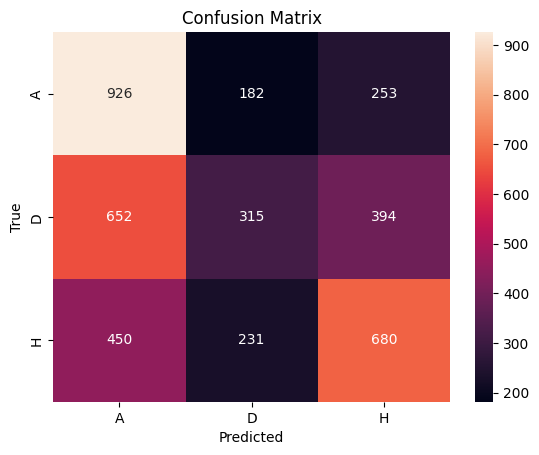

              precision    recall  f1-score   support

           0       0.51      0.67      0.58       209
           1       0.30      0.22      0.25       141
           2       0.62      0.55      0.59       274

    accuracy                           0.52       624
   macro avg       0.48      0.48      0.47       624
weighted avg       0.51      0.52      0.51       624

Accuracy: 0.5176282051282052
Precision: 0.47607676938165944
Recall: 0.4818647316215589
F1 Score: 0.4725169172449692


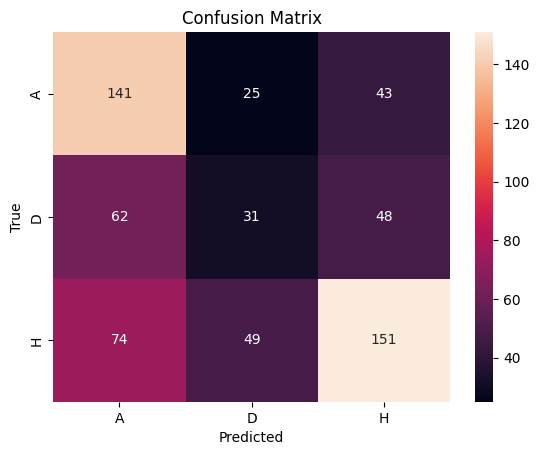

In [ ]:
clf_ovo = OneVsOneClassifier(LogisticRegression(C=10, penalty='l2', solver='liblinear', max_iter=1000, class_weight=class_weight))
cal_clf = CalibratedClassifierCV(clf_ovo, method='sigmoid', cv=5)
svm = SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42, class_weight=class_weight)
lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000, class_weight=class_weight)
nb = GaussianNB(var_smoothing=1e-15)

# Without RF: the f1 for class 1 (home win) is a bit better
# Without NB: the f1 for class 1 drops 1% but overall scores go up
voting_classifier = VotingClassifier(estimators=[ ('lr', lr), ('nb', nb), ('ovo', cal_clf)], voting='soft')
voting_classifier.fit(X_resampled, y_resampled)
print_cm(y_resampled, voting_classifier.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, voting_classifier.predict(X_test), 'macro', Encoder=label_encoder, class_report=True)

Not as good as we had hoped but decent.

Now lets try the first soft vote with a calibration and threshold tune

Accuracy: 0.4991427871662993
Precision: 0.49814742075344204
Recall: 0.49914278716629923
F1 Score: 0.49600209515256016


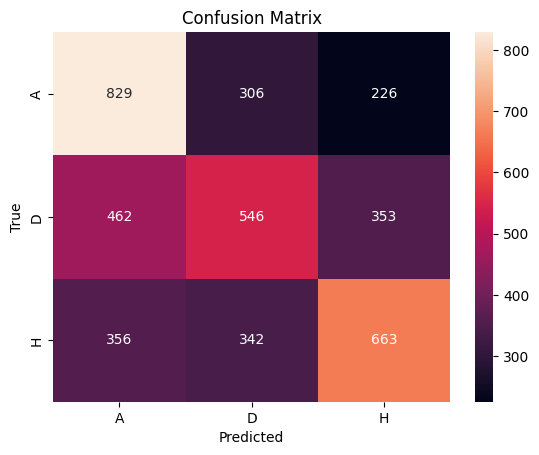

              precision    recall  f1-score   support

           0       0.57      0.60      0.59       209
           1       0.29      0.35      0.32       141
           2       0.63      0.54      0.58       274

    accuracy                           0.52       624
   macro avg       0.50      0.50      0.50       624
weighted avg       0.54      0.52      0.52       624

Accuracy: 0.5176282051282052
Precision: 0.4987180323600735
Recall: 0.4979923642800356
F1 Score: 0.4958623333749724


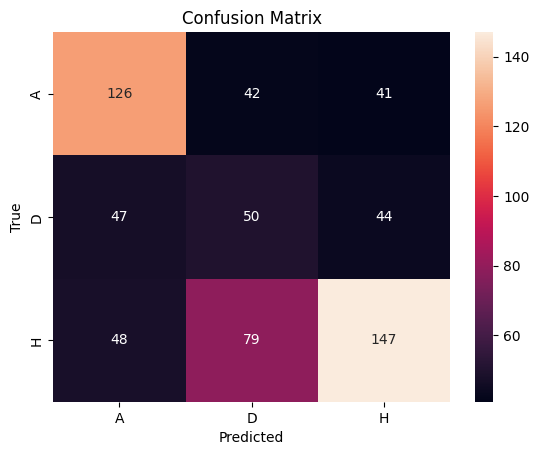

In [ ]:
svm = SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42, class_weight=class_weight)
lr = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000, class_weight=class_weight)
nb = GaussianNB(var_smoothing=1e-15)
voting_classifier = VotingClassifier(estimators=[('svm', svm), ('lr', lr), ('nb', nb)], voting='soft')
calibrated_soft = CalibratedClassifierCV(voting_classifier, method='sigmoid', cv=5)
calibrated_soft.fit(X_resampled, y_resampled)
probs = calibrated_soft.predict_proba(X_test)
classes = calibrated_soft.classes_
custom_preds = []
for prob in probs:
    p_draw = prob[classes.tolist().index(1)]
    p_win = prob[classes.tolist().index(2)]
    p_loss = prob[classes.tolist().index(0)]
    if abs(p_win - p_loss) < 0.1 and p_draw > 0.2:
        custom_preds.append(1)
    # if abs(p_win - p_draw) < 0.2 and (p_loss < p_win and p_loss < p_draw):
    #     custom_preds.append(1)
    # elif abs(p_draw - p_loss) < 0.2 and (p_win < p_loss and p_win < p_draw):
    #     custom_preds.append(1)
    else:
        custom_preds.append(np.argmax(prob))

print_cm(y_resampled, calibrated_soft.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, custom_preds, 'macro', Encoder=label_encoder, class_report=True)

Best F1 so far!!!

Quickly try stacking.

In [ ]:
# Stacking model
# DONT RUN THIS CELL IT TAKES ABOUT 25 MINUTES
# OUTPUT IF IT ACCIDENTALLY GETS DELETED:
# Best Parameters Accuracy: {'final_estimator__C': 10, 'final_estimator__gamma': 'scale', 'final_estimator__kernel': 'rbf'}
# Best Score Accuracy: 0.6536987400503514
# Best Parameters F1: {'final_estimator__C': 0.1, 'final_estimator__gamma': 'scale', 'final_estimator__kernel': 'linear'}
# Best Score F1: 0.6386822760945473

classifiers = [
    ('svm', SVC(probability=True, kernel='rbf', C=10, gamma='scale', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=42)),
    ('lr', LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000)),
    # ('gbm', GradientBoostingClassifier(n_estimators=150, learning_rate = 0.05, max_depth = 3, min_samples_leaf=3, min_samples_split=5, random_state=42))
    ('nb', GaussianNB(var_smoothing=1e-15))
]

stacking_svm_params = {
    'final_estimator__C': [0.01, 0.1, 1, 10],
    'final_estimator__kernel': ['linear', 'rbf'],
    'final_estimator__gamma': ['scale', 'auto']
}
# meta_classifier = LogisticRegression(C=1, penalty='l2', solver='lbfgs')
meta_classifier = SVC()
# meta_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=2, min_samples_split=5, random_state=42)

stacking_classifier = StackingClassifier(estimators=classifiers, final_estimator=meta_classifier)

# stacking_grid = GridSearchCV(stacking_classifier, stacking_svm_params, cv=5, scoring='accuracy', n_jobs=-1)
# stacking_grid.fit(X_train, y_train)

# print("Best Parameters Accuracy:", stacking_grid.best_params_)
# print("Best Score Accuracy:", stacking_grid.best_score_)

# stacking_grid = GridSearchCV(stacking_classifier, stacking_svm_params, cv=5, scoring='f1_macro', n_jobs=-1)
# stacking_grid.fit(X_train, y_train)

# print("Best Parameters F1:", stacking_grid.best_params_)
# print("Best Score F1:", stacking_grid.best_score_)
# stacking_classifier.fit(X_train, y_train)


Accuracy: 0.8234141562576537
Precision: 0.8292251743190509
Recall: 0.8234141562576537
F1 Score: 0.8197887298934229


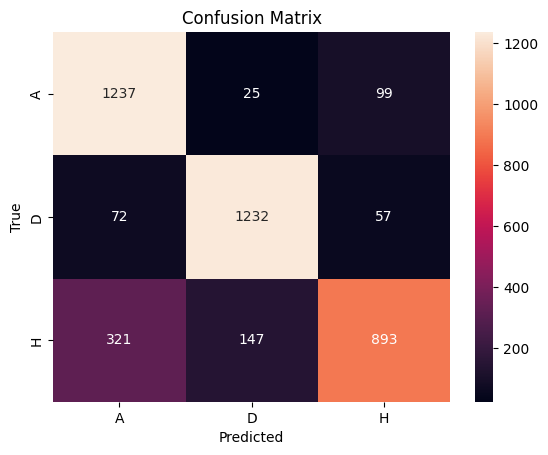

              precision    recall  f1-score   support

           0       0.51      0.58      0.54       209
           1       0.18      0.09      0.11       141
           2       0.57      0.66      0.62       274

    accuracy                           0.50       624
   macro avg       0.42      0.44      0.42       624
weighted avg       0.46      0.50      0.48       624

Accuracy: 0.5048076923076923
Precision: 0.41895974365882466
Recall: 0.4427624426807039
F1 Score: 0.4236387842202029


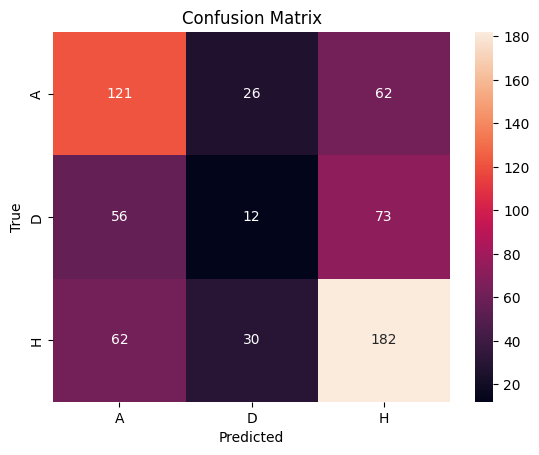

In [ ]:
meta_classifier = SVC(probability=True, kernel='rbf', C=10, gamma='scale', random_state=42)
stacking_classifier = StackingClassifier(estimators=classifiers, final_estimator=meta_classifier)
stacking_classifier.fit(X_resampled, y_resampled)
print_cm(y_resampled, stacking_classifier.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, stacking_classifier.predict(X_test), 'macro', Encoder=label_encoder,class_report=True)

Accuracy: 0.7927994121969141
Precision: 0.7931362813051038
Recall: 0.7927994121969141
F1 Score: 0.7915513071307637


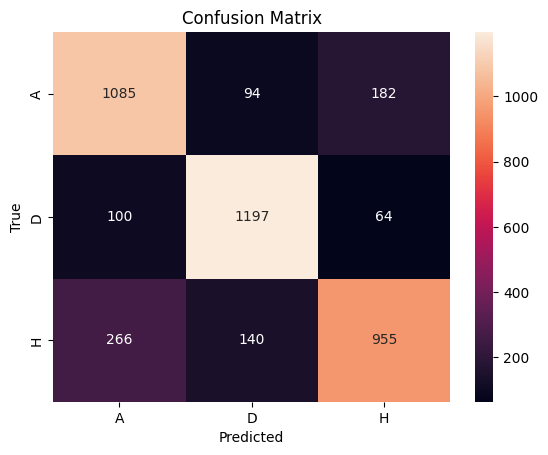

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       209
           1       0.23      0.19      0.21       141
           2       0.60      0.65      0.62       274

    accuracy                           0.51       624
   macro avg       0.45      0.46      0.46       624
weighted avg       0.49      0.51      0.50       624

Accuracy: 0.5080128205128205
Precision: 0.4543617614269788
Recall: 0.45862483723462466
F1 Score: 0.45548609207118657


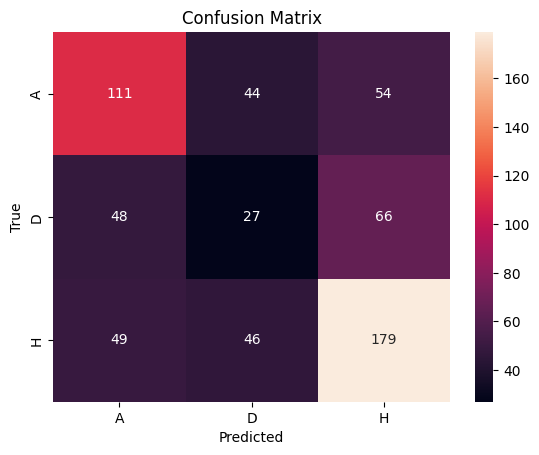

In [ ]:
# different hyperparams on the meta classifier
meta_classifier = SVC(probability=True, kernel='linear', C=0.1, gamma='scale', random_state=42)
stacking_classifier = StackingClassifier(estimators=classifiers, final_estimator=meta_classifier)
stacking_classifier.fit(X_resampled, y_resampled)
print_cm(y_resampled, stacking_classifier.predict(X_resampled), 'macro', Encoder=label_encoder)
print_cm(y_test, stacking_classifier.predict(X_test), 'macro', Encoder=label_encoder, class_report=True)

Better F1 but stacking still isn't awesome.

We've tried many different approaches but at the end of the day the draws are just really dificult to predict. They can just be a result of too many different factors and seem to not follow a strong pattern which makes sense. Throughout the making of this notebook there was many different variations of hyperparameters, probability thresholds, class weights etc. The ones in the notebook now are the ones we found to perform the best. Not all the models can be included in the final report so we will pick the ones that we think describe the data and process the best.